In [1]:
import pickle
import numpy as np
from tcn_class import TCN
from torch import nn
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
WIN_SIZE = 256
STRIDE = WIN_SIZE//64
PATH = 'default_test'
with open('data/{}/train.pkl'.format(PATH), 'rb') as f:
    train_np = pickle.load(f)

def prep_df(df, in_channels, win_size, stride):
    series_len = len(df[0])
    df_size = ((series_len - win_size) // stride) + 1
    torch_df = torch.FloatTensor(df_size, in_channels, win_size)

    for i in range(df_size):
        sample = df[:, stride*i: stride*i+win_size]
        torch_df[i] = sample
    residual_series = df[:, -win_size:].reshape(1,in_channels, -1)
    return torch_df, residual_series

in_channels = len(train_np)
train, train_resid = prep_df(train_np, in_channels, WIN_SIZE, STRIDE) 
train_size = train.shape[0]

from tcn_autoencoder import TCN_autoencoder

# model = TCN((in_channels, 24, 16, 24, in_channels), 3)
model = TCN_autoencoder(scale_factor=5, in_channels=in_channels, kernel_size=3, dropout=0) 
loss_history = []

  0%|          | 0/100 [00:00<?, ?it/s]

2.680687665939331
1.1631895303726196
0.8286429047584534
0.7035503387451172
0.6488847732543945
0.6242921948432922
0.6135541200637817
0.6091375350952148
0.607318639755249
0.606453537940979
0.6059479713439941
0.6056206822395325
0.6053869724273682
0.6052092909812927
0.6050704717636108
0.6049585938453674
0.6048651337623596
0.6047864556312561
0.6047190427780151
0.6046600937843323
0.6046175956726074


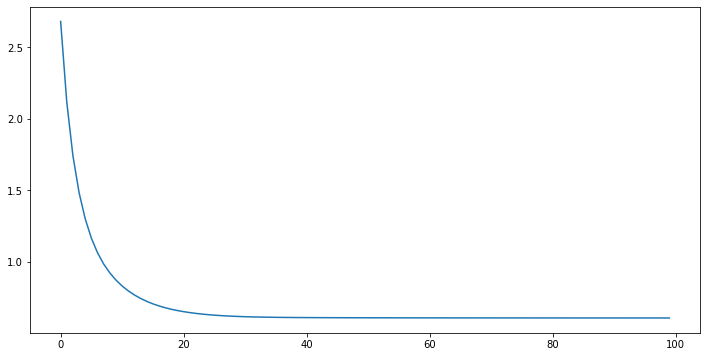

In [3]:
epochs_n = 100
learning_rate = 1e-3
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

for ep in tqdm(range(epochs_n)):
    ep_loss = 0
    pred = model(train)
    loss = criterion(pred, train)

    pred_resid = model(train_resid)
    loss_resid = criterion(pred_resid, train_resid)
    loss = (loss*train_size + loss_resid) / (train_size + 1)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_history.append(loss.item())

    if ep % 5 == 0:
        print(loss.item()) 

print(loss.item()) 
plt.figure(figsize=(12,6))
plt.plot(loss_history[:]) 

0.6046074163495448


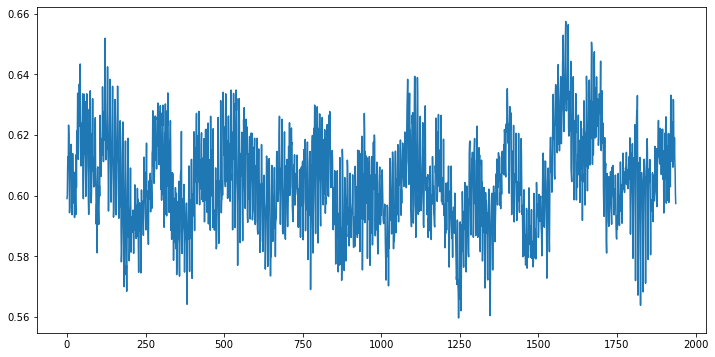

In [4]:
with torch.no_grad():
    train_loss = []
    for sample in train:
        pred = model(sample.reshape(1, in_channels, -1))
        loss = criterion(pred, sample.reshape(1, in_channels, -1))
        train_loss.append(loss.item())

    pred_resid = model(train_resid)
    loss_resid = criterion(pred_resid, train_resid)
    train_loss.append(loss_resid.item())

plt.figure(figsize=(12,6))
plt.plot(train_loss)
print(np.mean(train_loss))

0.5993407662600687


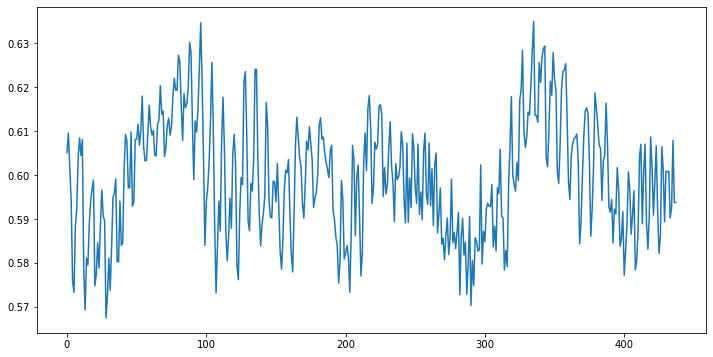

In [5]:
with open('data/{}/valid.pkl'.format(PATH), 'rb') as f:
    valid_np = pickle.load(f)

valid, valid_resid = prep_df(valid_np, in_channels, WIN_SIZE, STRIDE)
valid_size = valid.shape[0]

with torch.no_grad():
    valid_loss = []
    for sample in valid:
        pred = model(sample.reshape(1, in_channels, -1))
        loss = criterion(pred, sample.reshape(1, in_channels, -1))
        valid_loss.append(loss.item())

    pred_resid = model(valid_resid)
    loss_resid = criterion(pred_resid, valid_resid)
    valid_loss.append(loss_resid.item())

plt.figure(figsize=(12,6))
plt.plot(valid_loss)
print(np.mean(valid_loss))
max_valid_er = np.max(valid_loss)


0.6109620236841733


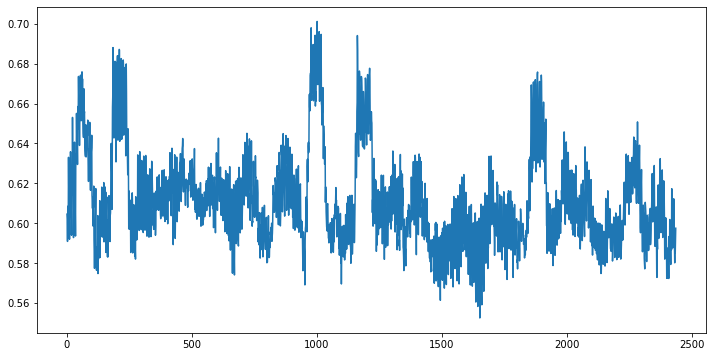

In [6]:
with open('data/{}/test.pkl'.format(PATH), 'rb') as f:
    test_np = pickle.load(f)

test, test_resid = prep_df(test_np, in_channels, WIN_SIZE, STRIDE)
with torch.no_grad():
    test_loss = []
    for sample in test:
        pred = model(sample.reshape(1, in_channels, -1))
        loss = criterion(pred, sample.reshape(1, in_channels, -1))
        test_loss.append(loss.item())
    
    pred_resid = model(test_resid)
    loss_resid = criterion(pred_resid, test_resid)
    test_loss.append(loss_resid.item())

plt.figure(figsize=(12,6))
plt.plot(test_loss)
print(np.mean(test_loss))

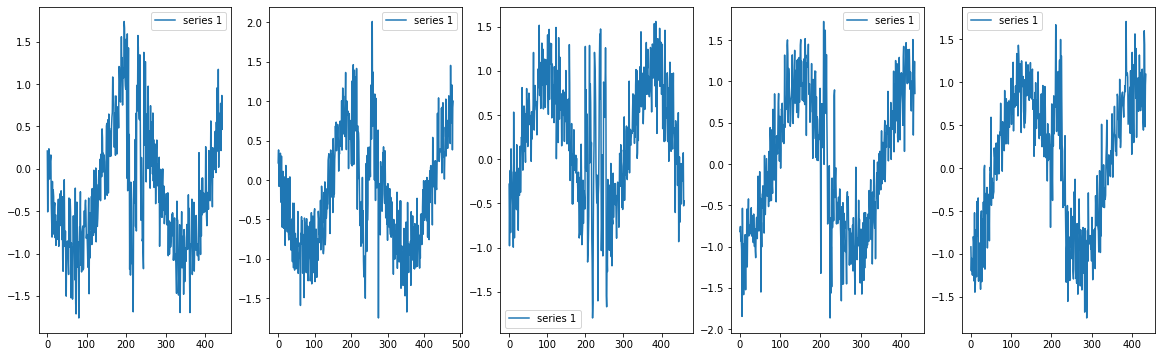

In [7]:
with open('data/{}/errors_positions.pkl'.format(PATH), 'rb') as f:
    er_pos = pickle.load(f)
er_start = er_pos[0]
er_end = er_pos[1]
er_start = np.sort(er_start)
er_end = np.sort(er_end)

ser_w_er = [1, 26, 9]
fig = plt.figure(figsize=(20,6))
for i in range(5):
    ax = fig.add_subplot(151+i)
    for j in range(1):
        ax.plot(test_np[ser_w_er[j], er_start[i]-200: er_end[i]+200],  label='series {}'.format(ser_w_er[j]))
    plt.legend()

    

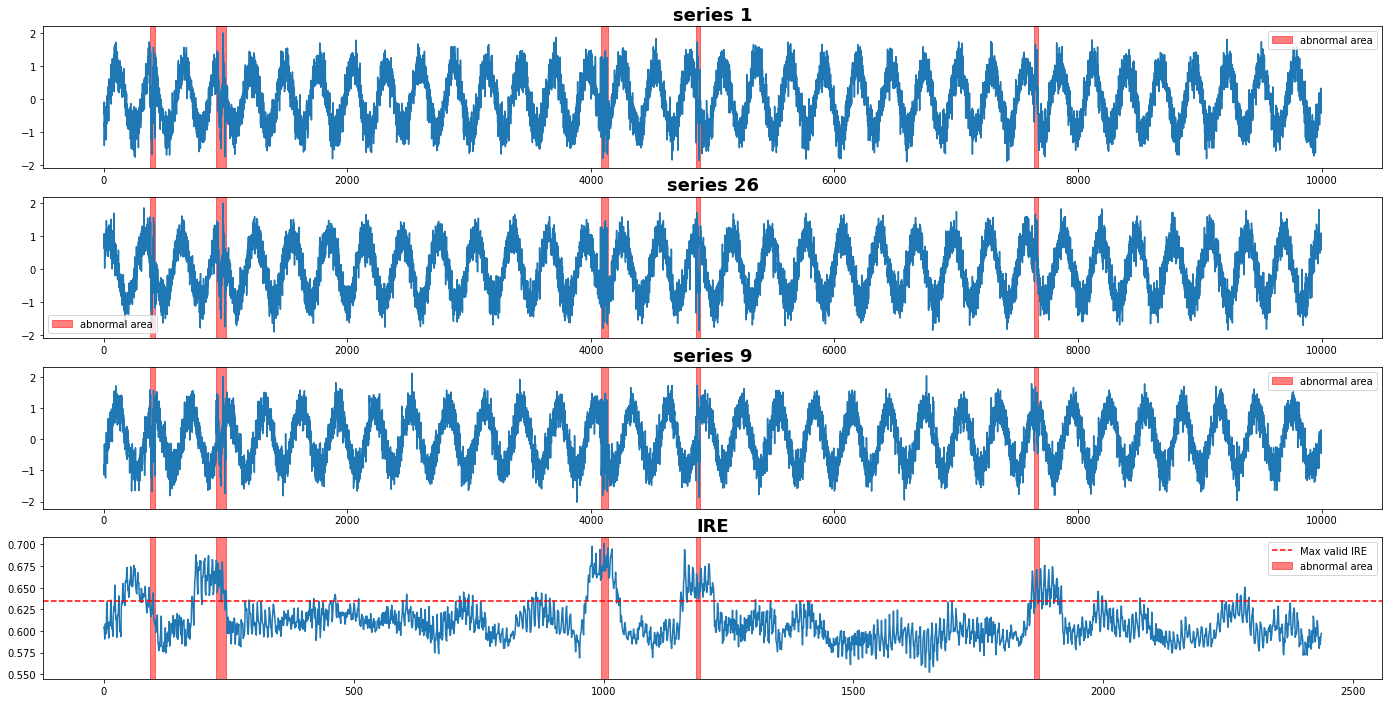

In [8]:
test_size = (test_np.shape[1] - WIN_SIZE)//STRIDE
resid_part = test_np.shape[1] - (test_size*STRIDE) - WIN_SIZE

fig = plt.figure(figsize=(24,12))

# test_np_ct = test_np[:, :99*STRIDE+WIN_SIZE]
test_np_ct = test_np
test_sec_size = test_np_ct.shape[1]
test_loss_size = len(test_loss)
sec_loss_scale = test_sec_size/test_loss_size

ax1 = fig.add_subplot(411)
ax1.plot(test_np_ct[ser_w_er[0]])
ax1.set_title('series {}'.format(ser_w_er[0]), weight='bold', size=18)

ax2 = fig.add_subplot(412)
ax2.plot(test_np_ct[ser_w_er[1]])
ax2.set_title('series {}'.format(ser_w_er[1]), weight='bold', size=18)

ax3 = fig.add_subplot(413)
ax3.plot(test_np_ct[ser_w_er[2]])
ax3.set_title('series {}'.format(ser_w_er[2]), weight='bold',  size=18)

ax4 = fig.add_subplot(414)
ax4.plot(test_loss)
ax4.set_title('IRE', weight='bold',  size=18)

is_first = True
for start, end in zip(er_start, er_end):
    if is_first:
        params = {  'color':'red',
                    'alpha':0.5,
                    'label':'abnormal area' }
        is_first = False
    else:
        params = {  'color':'red',
                    'alpha':0.5 }
    ax1.axvspan(start, end, **params)
    ax2.axvspan(start, end, **params)
    ax3.axvspan(start, end, **params)
    ax4.axvspan(start/sec_loss_scale, end/sec_loss_scale, **params)
    # ax4.axvspan(start/sec_loss_scale, end/sec_loss_scale, color='red', alpha=0.5, label='abnormal area')

anomaly_border = max_valid_er 
ax4.axhline(anomaly_border, color='r', linestyle='--', label='Max valid IRE') 
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()